# Different implementations to predict students graduation time 
## 1: Import Libraries and Modules

In [28]:
import sys
sys.path.append('../src')

import pandas as pd
from data_loader import DataLoader
from features import FeatureEngineer
from train import Trainer
from evaluate import plot_confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 2: Load Raw Data

In [29]:
data_path = '../data/raw/graduation_rate.csv'
loader = DataLoader(data_path)
df = loader.load_data()
df = loader.basic_cleaning(df)

print("Dataset loaded and cleaned")
print(df.shape)
print(df.head())

Dataset loaded and cleaned
(1000, 7)
   ACT composite score  SAT total score parental level of education  \
0                   22             1625                 high school   
1                   29             2090          associate's degree   
2                   30             2188           bachelor's degree   
3                   33             2151          associate's degree   
4                   29             2050          associate's degree   

   parental income  high school gpa  college gpa  years to graduate  
0            40999              3.0          3.1                  7  
1            75817              4.0          3.4                  5  
2            82888              4.0          3.9                  3  
3            93518              4.0          3.7                  5  
4            79153              4.0          3.4                  6  


## 3: Feature Engineering

In [30]:
target_col = 'years to graduate'

# Identify categorical and numeric features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

numeric_cols = df.select_dtypes(include='number').columns.tolist()

from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Yes -> 1, No -> 0

#numeric_cols.remove('years to graduate')  # Assuming 'years to graduate' is target

fe = FeatureEngineer()
df = fe.encode_categoricals(df, categorical_cols)
df = fe.scale_features(df, numeric_cols)

print("Feature engineering completed")
print(df.head())

Feature engineering completed
   ACT composite score  SAT total score  parental level of education  \
0            -2.382770        -2.585455                            2   
1             0.141733         0.621313                            0   
2             0.502376         1.297148                            1   
3             1.584306         1.041986                            0   
4             0.141733         0.345462                            0   

   parental income  high school gpa  college gpa  years to graduate  
0        -1.401795        -2.462772    -1.166368           1.427771  
1         0.448463         1.018670     0.099131           0.012735  
2         0.824222         1.018670     2.208296          -1.402301  
3         1.389110         1.018670     1.364630           0.012735  
4         0.625741         1.018670     0.099131           0.720253  


C:\Users\USEF\AppData\Local\Temp\ipykernel_18376\4278223852.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include='object').columns.tolist()


## 4: Train models

In [31]:
target_col = 'years to graduate'  # Assuming this is the target
trainer = Trainer(df, target_col)
results = trainer.train_models()

print("\nModel Training Results:")
for model_name, metrics in results.items():
    print(
        f"{model_name}: "
        f"MAE={metrics['mae']:.4f}, "
        f"RMSE={metrics['rmse']:.4f}, "
        f"R2={metrics['r2']:.4f}"
    )


Model Training Results:
Linear Regression: MAE=0.7025, RMSE=0.8582, R2=0.2418
Random Forest: MAE=0.7223, RMSE=0.8951, R2=0.1752
Gradient Boosting: MAE=0.7295, RMSE=0.8995, R2=0.1671


## 5: Evaluate Best Model (Random Forest)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
############
# Evaluate properly
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


MAE: 0.7223
RMSE: 0.8951
R2: 0.1752


## 6: plot

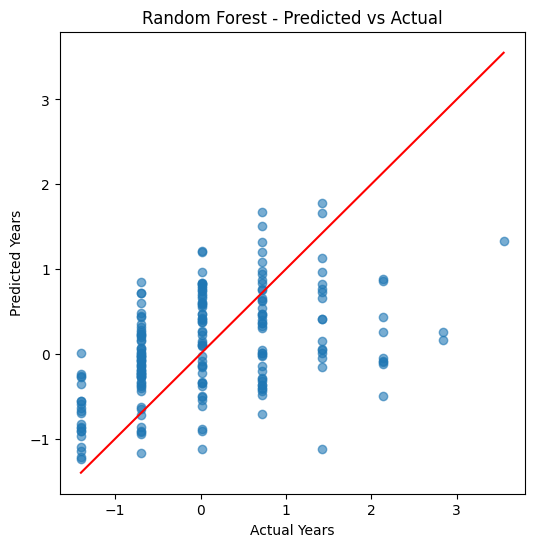

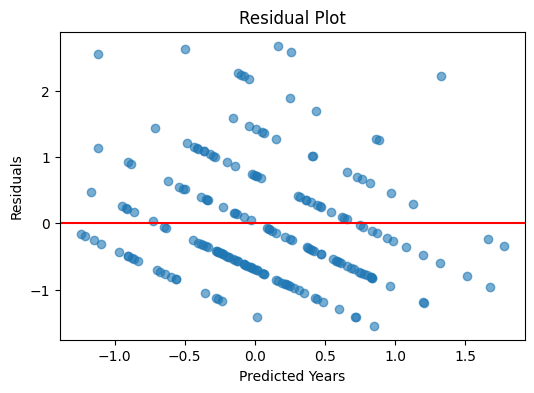

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Years")
plt.ylabel("Predicted Years")
plt.title("Random Forest - Predicted vs Actual")

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Predicted Years")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


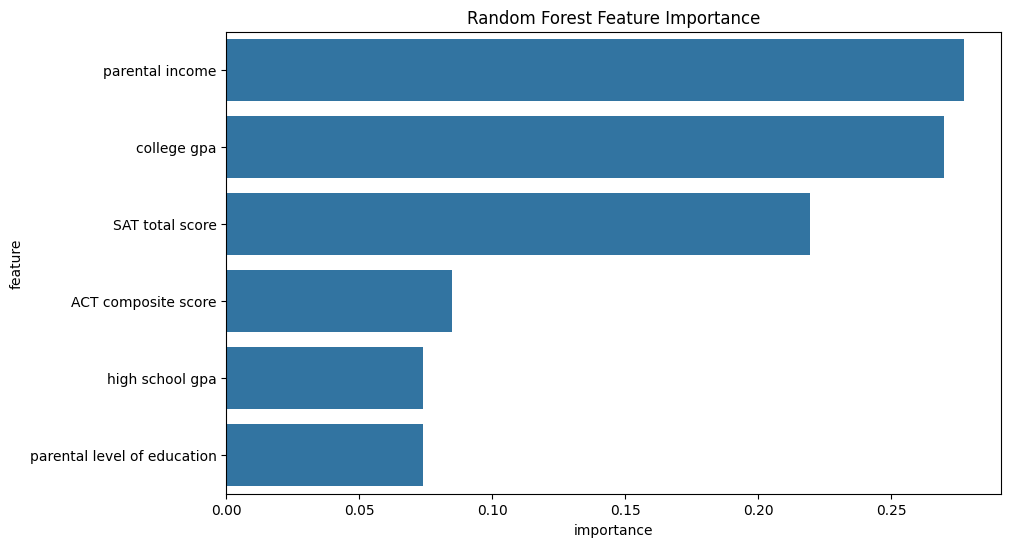

In [34]:
importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("Random Forest Feature Importance")
plt.show()

In [35]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Residuals
residuals = y_test - y_pred

print("===== Regression Evaluation Summary =====\n")

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R2   : {r2:.4f}\n")

print("Residual Statistics:")
print(f"Mean Residual        : {np.mean(residuals):.4f}")
print(f"Std of Residuals     : {np.std(residuals):.4f}")
print(f"Min Residual         : {np.min(residuals):.4f}")
print(f"Max Residual         : {np.max(residuals):.4f}\n")

# Correlation between actual and predicted
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Correlation (Actual vs Predicted): {correlation:.4f}")


===== Regression Evaluation Summary =====

MAE  : 0.7223
RMSE : 0.8951
R2   : 0.1752

Residual Statistics:
Mean Residual        : -0.0206
Std of Residuals     : 0.8949
Min Residual         : -1.5424
Max Residual         : 2.6744

Correlation (Actual vs Predicted): 0.4524


In [36]:
import pandas as pd

importance = pd.Series(best_model.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False))


parental income                0.277503
college gpa                    0.269977
SAT total score                0.219347
ACT composite score            0.084934
high school gpa                0.074194
parental level of education    0.074045
dtype: float64
